# Wine Quality Prediction Project

## Goal:
- Discover features that affect wine quality
- Use features to develop a machine learning model to predict the quality of wine on a scale of 1-10

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
# import explore as e
# import model as m
# import evaluate as ev

from scipy.stats import pearsonr, spearmanr, f_oneway, ttest_ind

np.random.seed(123)

# Acquire
- Data acquired from [data.world](https://data.world/food/wine_quality)
- Downloaded two separate .csv files: 1 for red wine, 1 for white wine
- Merged the .csv files into a a single dataframe
- Added one column, wine_type, after combining csv files to indicate red or white wine
- It contained 6,497 rows and 13 columns before cleaning
    - 1599 rows were red wines
    - 4898 rows were white wines
- Each row represents a single vintage of wine
- Each column represents a chemical quality of the wines

# Prepare
- Did not remove any columns
- Did not rename any columns
- Checked for nulls - no null values found
- Checked that column data types were appropriate
- Outliers: used IQR method and 2 for the multiplier value:
    - IQR = Q3 - Q1;  For each column: removed (Q1 - 2 * IQR) AND removed (Q3 + 2 * IQR)
    - 867 rows removed
    - Began with 6,497
    - Ended with 5,630
- Encoded categorical variables
- Split data into train, validate, and test (60/20/20)
- Scaled continuous variables

# Data Dictionary

| Feature | Definition (measurement)|
|:--------|:-----------|
|Fixed Acidity| The fixed amount of tartaric acid. (g/L)|
|Volatile Acidity| A wine's acetic acid; (High Volatility = High Vinegar-like smell). (g/L)|
|Citric Acid| The amount of citric acid; (Raises acidity, Lowers shelf-life). (g/L)|
|Residual Sugar| Leftover sugars after fermentation. (g/L)|
|Chlorides| Increases sodium levels; (Affects color, clarity, flavor, aroma). (g/L)|
|Free Sulfur Dioxide| Related to pH. Determines how much SO2 is available. (Increases shelf-life, decreases palatability). (mg/L)|
|Total Sulfur Dioxide| Summation of free and bound SO2. (Limited to 350ppm: 0-150, low-processed, 150+ highly processed). (mg/L)|
|Density| Between 1.08 and 1.09. (Insight into fermentation process of yeast growth). (g/L)|
|pH| 2.5: more acidic - 4.5: less acidic (range)|
|Sulphates| Added to stop fermentation (Preservative) (g/L)|
|Alcohol| Related to Residual Sugars. By-product of fermentation process (vol%)|
|Quality (Target)| Score assigned between 0 and 10; 0=low, 10=best|
|Wine Type| Red or White|

In [2]:
# acquire and prepare wine data
df = w.wrangle_wine()

Total of rows originally: 6497
Total of rows removed: 867
New total of rows: 5630


In [3]:
# split into train/validate/test datasets (tr/val/ts)
tr, val, ts = w.get_split(df)

Train: (3378, 13)
Validate: (1126, 13)
Test: (1126, 13)


# A brief look at the data

In [4]:
tr.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type_white_wine
2980,5.7,0.43,0.30,5.7,0.039,24.0,98.0,0.99200,3.54,0.61,12.3,7,1
4035,6.9,0.43,0.28,9.4,0.056,29.0,183.0,0.99594,3.17,0.43,9.4,5,1
3741,7.5,0.26,0.52,13.2,0.047,64.0,179.0,0.99820,3.10,0.46,9.0,5,1
4485,6.6,0.41,0.31,1.6,0.042,18.0,101.0,0.99195,3.13,0.41,10.5,5,1
5778,6.9,0.24,0.40,15.4,0.052,81.0,198.0,0.99860,3.20,0.69,9.4,5,1


## A summary of the data

In [5]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3378 entries, 2980 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         3378 non-null   float64
 1   volatile_acidity      3378 non-null   float64
 2   citric_acid           3378 non-null   float64
 3   residual_sugar        3378 non-null   float64
 4   chlorides             3378 non-null   float64
 5   free_sulfur_dioxide   3378 non-null   float64
 6   total_sulfur_dioxide  3378 non-null   float64
 7   density               3378 non-null   float64
 8   ph                    3378 non-null   float64
 9   sulphates             3378 non-null   float64
 10  alcohol               3378 non-null   float64
 11  quality               3378 non-null   int64  
 12  wine_type_white_wine  3378 non-null   uint8  
dtypes: float64(11), int64(1), uint8(1)
memory usage: 346.4 KB


In [6]:
tr.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_type_white_wine
count,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000,3378.000000
mean,6.996137,0.318283,0.303535,5.641933,0.048866,31.185465,120.457075,0.994345,3.219982,0.511578,10.541462,5.867377,0.818532
std,0.960999,0.136004,0.118204,4.723342,0.017296,16.269405,52.878207,0.002875,0.154876,0.122579,1.213733,0.870771,0.385463
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.250000,8.400000,3.000000,0.000000
25%,6.400000,0.220000,0.240000,1.800000,0.037000,18.000000,88.000000,0.992000,3.110000,0.420000,9.500000,5.000000,1.000000
50%,6.900000,0.280000,0.300000,3.600000,0.045000,30.000000,121.000000,0.994400,3.210000,0.500000,10.400000,6.000000,1.000000
75%,7.500000,0.380000,0.370000,8.500000,0.056000,42.000000,156.000000,0.996600,3.320000,0.587500,11.400000,6.000000,1.000000
max,10.200000,0.745000,0.630000,20.800000,0.102000,87.000000,282.000000,1.001960,3.720000,0.920000,14.000000,9.000000,1.000000


# Explore

## What is the distribution of the target?)
- NOTE: this question is more of a look at the data, not a stats test question

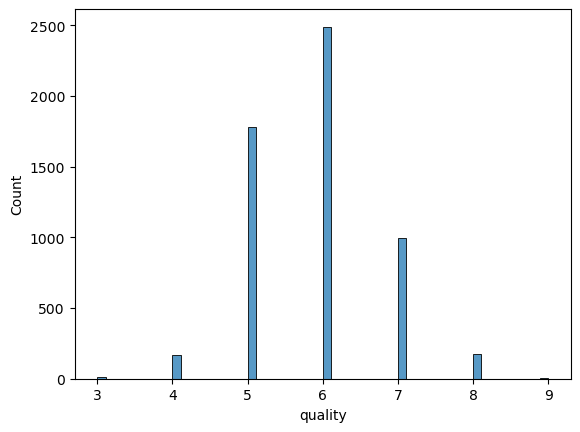

In [7]:
# get a histplot of quality
sns.histplot(df.quality)
plt.show()

## Question 1: Is alcohol associated with quality?

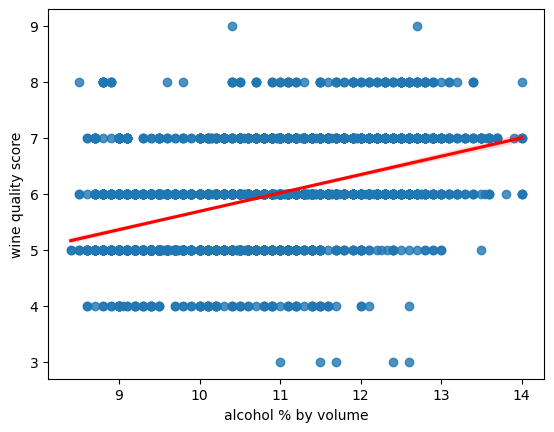

In [8]:
# Visualize: get a regplot of alcohol vs quality on train
sns.regplot(data = tr, x= 'alcohol', y='quality', line_kws = {'color': 'red'})
plt.xlabel('alcohol % by volume')
plt.ylabel('wine quality score')
plt.show()

### Analyze alcohol vs quality with stats
- $H_0$: There is NO relationship between alcohol and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [9]:
# get the stats from a pearsonr test on alcohol vs quality
spearmanr(tr.alcohol, tr.quality)

SpearmanrResult(correlation=0.46234896005122295, pvalue=1.456181106276295e-178)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between alcohol and quality: as alcohol by volume increases, quality increases in the dataset

## Question 2: Is chlorides associated with quality?)

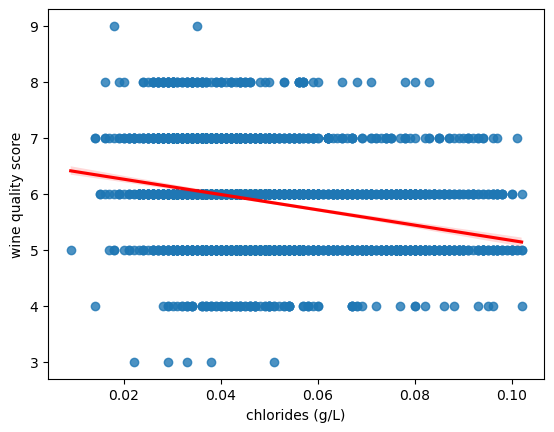

In [10]:
# Visualize: get a regplot of chlorides vs quality
sns.regplot(data=tr, x='chlorides', y='quality', line_kws = {'color': 'red'})
plt.xlabel('chlorides (g/L)')
plt.ylabel('wine quality score')
plt.show()

### Analyze chlorides vs quality with stats
- $H_0$: There is NO relationship between chlorides and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [11]:
# get the stats from a pearsonr test on chlorides vs quality
spearmanr(tr.chlorides, tr.quality)

SpearmanrResult(correlation=-0.3145155116581846, pvalue=1.9029656621476643e-78)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between chlorides and quality: a lower value for chlorides correlates with an increase in quality

## Question 3 Is residual_sugar associated with quality?

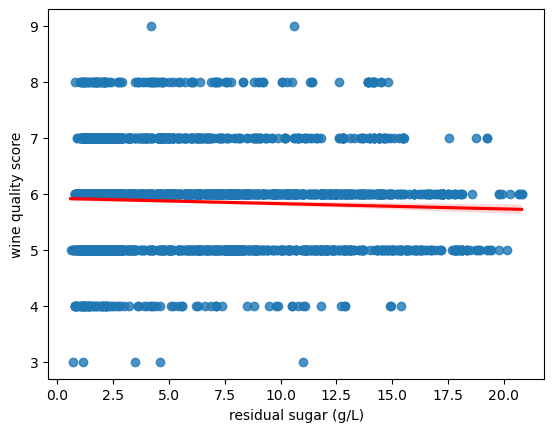

In [12]:
# Visualize: get a regplot of residual_sugar vs quality on train
sns.regplot(data=tr, x='residual_sugar', y='quality', line_kws = {'color': 'red'})
plt.xlabel('residual sugar (g/L)')
plt.ylabel('wine quality score')
plt.show()

### Analyze residual_sugar vs quality with stats
- $H_0$: There is NO relationship between residual_sugar and quality
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [13]:
# get the stats from a pearsonr test on chlorides vs quality
spearmanr(tr.residual_sugar, tr.quality)

SpearmanrResult(correlation=-0.029565525964640713, pvalue=0.08577753023737957)

### Summarize
- p is > $\alpha$, so we CANNOT reject the $H_0$ i.e. there is NOT a relationship between residual_sugar and quality

## Question 4 Is alcohol associated with density?
- Chemistry knowledge suggest these two features are very closely related, and therefore we should, perhaps, only send one in to our models

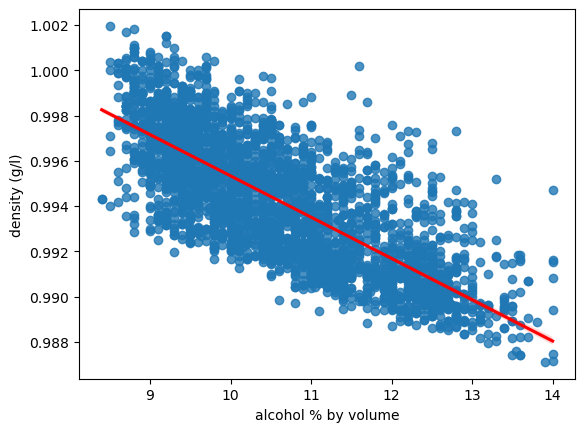

In [14]:
# Visualize: get a regplot of alcohol vs density on train
sns.regplot(data=tr, x='alcohol', y='density', line_kws = {'color': 'red'})
plt.xlabel('alcohol % by volume')
plt.ylabel('density (g/l)')
plt.show()

### Analyze alcohol vs density with stats
- $H_0$: There is NO relationship between alcohol and density
- $H_a$: There IS a relationship
- $\alpha$ = .05
    - Utilize spearmanr - we are comparing continuous variables, normally distributed, but UNequal variance

In [15]:
# get the stats from a pearsonr test on alcohol vs density
spearmanr(tr.alcohol, tr.density)

SpearmanrResult(correlation=-0.7729668005975888, pvalue=0.0)

### Summarize
- p is < $\alpha$, so we can reject the $H_0$ which suggest the $H_a$, i.e. there IS a relationship between alcohol and density; furthermore, the correlation coefficient is -0.77, i.e. highly correlated (closer to -1 is more correlated)

## Exploration Summary
* No feature had a strong correlation with quality by itself; alcohol was the strongest with a .46 correlation coefficient
* However, most features had some relationship with quality by themselves (stats tests for other features completed in separate working notebook)
* density was closely correlated with alcohol
* PUT SOMETHING IN HERE ABOUT CLUSTERS


### Features we are moving to modeling with
* fixed_acidity
* volatile_acidity
* citric_acid
* chlorides
* free_sulfur_dioxide
* total_sulfur_dioxide
* ph
* sulphates
* alcohol
* wine_type

### Features we are not moving to modeling with
* residual_sugar
* density

# Modeling
* Evaluation Metrics (example: I will use R^2 and Root Mean Square Error (RMSE) as my evaluation metrics)
    * for R^2, the value is in the range 0-1; closer to 1.0 is better; baseline is 0.0
    * for RMSE, the lower the value the better; baseline is xxx
* The average target is xxx which is the baseline prediction
* I will evaluate x different model types and various hyperparameter configurations
    * (Example: The four model types are Ordinary Least Squares (OLS), LassoLars, Polynomial Regression, Generalized Linear Model (GLM))
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [17]:
## prep data for modeling

# get X y splits for modeling
target = 'quality'
X_tr, X_val, X_ts, y_tr, y_val, y_ts, to_scale, baseline = w.get_Xs_ys_to_scale_baseline(tr, val, ts, target)

# scaling continuous variable columns for use in modeling
X_tr_sc, X_val_sc, X_ts_sc = w.scale_data(X_tr,X_val,X_ts,to_scale)
print(f'Baseline Prediction (mean of quality) = {baseline}')

Baseline Prediction (mean of quality) = 5.867377146240379


## Model Name (example: Ordinary Least Squares (OLS) Regression)

In [ ]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: LassoLars)

In [ ]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: Polynomial Regression)

In [ ]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Model Name (example: Generalized Linear Model (GLM))

In [ ]:
# get model results
# INSERT CODE HERE

* model name did/did not beat baseline

## Comparing Models
* summarize the model performance
* ...
* I have chosen to move forward with the ___ model on test

## Best Model (model name) on Test

In [ ]:
# get test results for final model
# INSERT CODE HERE

In [ ]:
# maybe a visual of model performance (like a residual plot for a regression model)

## Modeling Summary
* summary bullet 1 ...

# Conclusions

## Exploration
* bullets

## Modeling
* bullets

## Recommendations
* bullets

## Next steps
* build separate models for the two wine types to see if that would improve model accuracy